In [1]:
import pandas as pd

RANDOM_SEED = 42

# 1. Load the data into a pandas data frame.
df = pd.read_csv('Youtube05-Shakira.csv')

# 2. Carry out some basic data exploration and present your results. 
print("----------------------------")
print("Shape: ", df.shape)
print("----------------------------")
print("Columns: ", df.columns.tolist())

df = df.drop(['COMMENT_ID', 'DATE', 'AUTHOR'], axis=1)

import re 
# Data Preprocessing Function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

# Apply preprocessing to the content column
df['CONTENT'] = df['CONTENT'].apply(preprocess_text)


# 2. Carry out some basic data exploration and present your results. 
print("----------------------------")
print("Shape: ", df.shape)
print("----------------------------")
print("Columns: ", df.columns.tolist())
print("----------------------------")
print("Data Types:\n\n",df.dtypes)
print("----------------------------")
print("Missing values:\n\n", df.isnull().sum())
print("----------------------------")
print("Unique values:\n\n", df.nunique())

----------------------------
Shape:  (370, 5)
----------------------------
Columns:  ['COMMENT_ID', 'AUTHOR', 'DATE', 'CONTENT', 'CLASS']
----------------------------
Shape:  (370, 2)
----------------------------
Columns:  ['CONTENT', 'CLASS']
----------------------------
Data Types:

 CONTENT    object
CLASS       int64
dtype: object
----------------------------
Missing values:

 CONTENT    0
CLASS      0
dtype: int64
----------------------------
Unique values:

 CONTENT    316
CLASS        2
dtype: int64


----------------------------
New shape:  (370, 1291)
Feature names:  ['025' '0687119038' '10' ... 'youtubers' 'zealous' 'zonepacom']


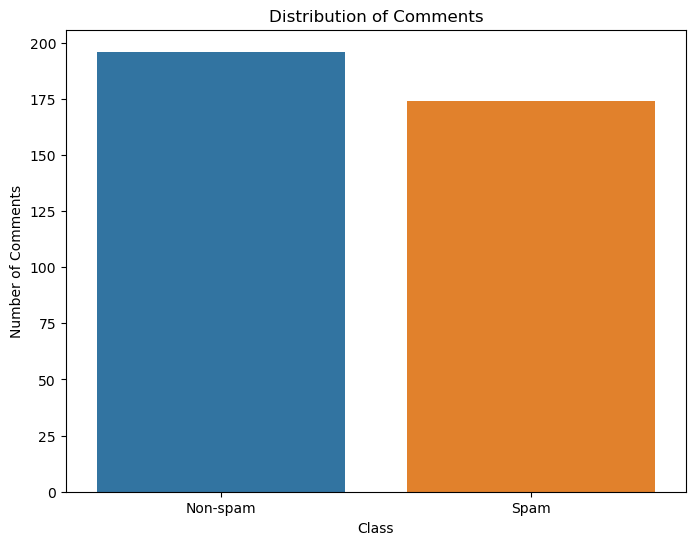

In [2]:
#import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

# 3. Using nltk toolkit classes and methods prepare the data for model building, refer to the third lab tutorial in module 11 (Building a Category text predictor ). Use count_vectorizer.fit_transform()
#nltk.download('punkt')
count_vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
dtm = count_vectorizer.fit_transform(df['CONTENT'])

# 4. Present highlights of the output (initial features) such as the new shape of the data and any other useful information before proceeding.
print("----------------------------")
print("New shape: ", dtm.shape)
print("Feature names: ", count_vectorizer.get_feature_names_out())


# Data distribution 
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = df['CLASS'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Comments')
plt.xlabel('Class')
plt.ylabel('Number of Comments')
plt.xticks(ticks=[0, 1], labels=['Non-spam', 'Spam']) 
plt.show()

----------------------------
TF-IDF Matrix Shape:  (370, 1291)


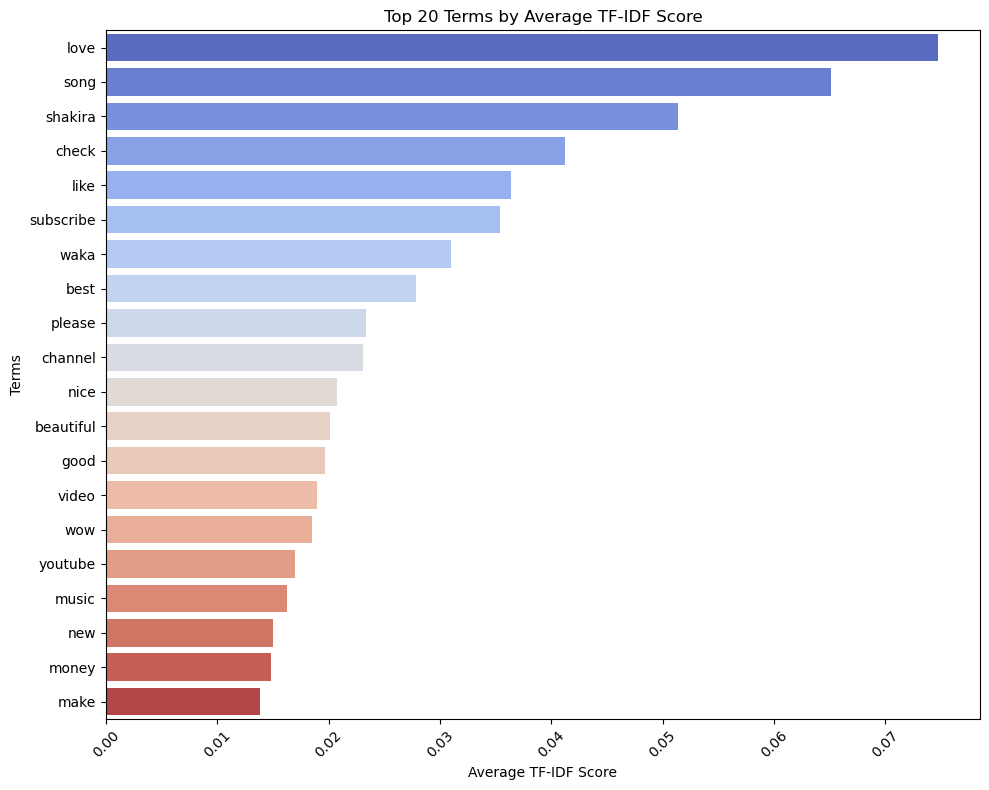

In [3]:
#Part 3 - Model training
from sklearn.feature_extraction.text import TfidfTransformer

# 5. Downscale the transformed data using tf-idf and again present highlights of the output (final features) such as the new shape of the data and any other useful information before proceeding.
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(dtm)
print("----------------------------")
print("TF-IDF Matrix Shape: ", tfidf.shape)

import numpy as np

tfidf_df = pd.DataFrame(tfidf.toarray(), columns=count_vectorizer.get_feature_names_out())
avg_tfidf = tfidf_df.mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(10,8))
sns.barplot(x=avg_tfidf.values, y=avg_tfidf.index, palette='coolwarm')
plt.title('Top 20 Terms by Average TF-IDF Score')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Terms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
# 6. Use pandas.sample to shuffle the dataset, set frac =1
df_shuffled = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# 7. Using pandas split your dataset into 75% for training and 25% for testing, make sure to separate the class from the feature(s). (Do not use test_train_ split)
train_size = int(0.75 * len(df_shuffled))
train_df = df_shuffled[:train_size]
test_df = df_shuffled[train_size:]

x_train = train_df['CONTENT']
y_train = train_df['CLASS']
x_test = test_df['CONTENT']
y_test = test_df['CLASS']

In [5]:
# 8. Fit the training data into a Naive Bayes classifier.

from sklearn.naive_bayes import MultinomialNB

x_train_counts = count_vectorizer.fit_transform(x_train)
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
x_test_counts = count_vectorizer.transform(x_test) 
x_test_tfidf = tfidf_transformer.transform(x_test_counts)  

clf = MultinomialNB().fit(x_train_tfidf, y_train)

# Part 4 - Model testing
# 9. Cross validate the model on the training data using 5-fold and print the mean results of model accuracy.
print("----------------------------")
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, x_train_tfidf, y_train, cv=5)
print("Mean accuracy: {:.2f}".format(scores.mean()))


----------------------------
Mean accuracy: 0.87


----------------------------
Confusion Matrix: 
[[47  1]
 [ 4 41]]


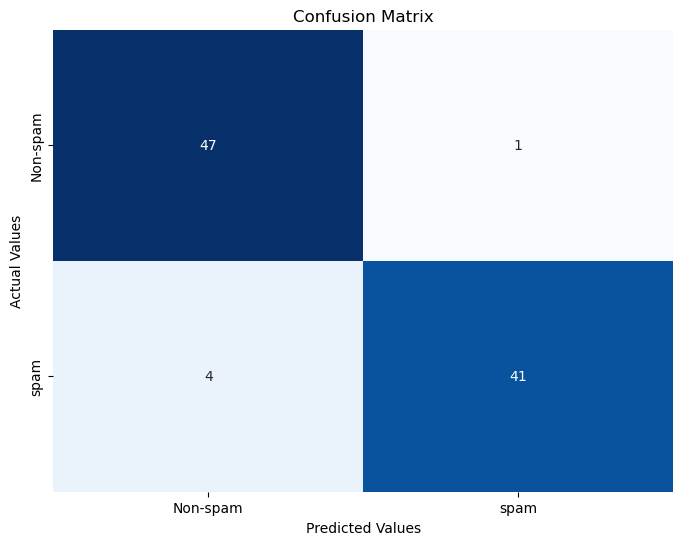

----------------------------
Accuracy: 0.95


In [6]:
# 10. Test the model on the test data, print the confusion matrix and the accuracy of the model.
y_pred = clf.predict(x_test_tfidf)

from sklearn.metrics import confusion_matrix, accuracy_score
conf_matrix = confusion_matrix(y_test, y_pred)
print("----------------------------")
print("Confusion Matrix: ")
print(conf_matrix)

import matplotlib.pyplot as plt
import seaborn as sns

labels=['Non-spam','spam'] # 0 = Non-spam, 1 = Spam
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

print("----------------------------")
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))

In [7]:
# Part 5
# 11. As a group come up with 6 new comments (4 comments should be non spam and 2 comment spam) and pass them to the classifier and check the results. You can be very creative and even do more
new_comments = [
   "This is a great song!",  # Non-spam: Positive feedback
    "I love this video.",  # Non-spam: Positive feedback
    "Check out my channel for more amazing content!",  # Spam: Promotional content
    "Best performance ever.",  # Non-spam: Positive feedback
    "Buy products at a discount here: [link]",  # Spam: Promotional content with link
    "Absolutely stunning performance!",  # Non-spam: Positive feedback
    "Join my webinar on how to become famous overnight!",  # Spam: Promotional, potentially misleading
    "This video is so relaxing and inspiring.",  # Non-spam: Positive feedback
    "Cheap watches for sale at www.watchsale.com",  # Spam: Promotional content with URL
    "This doesn't seem real.",  # Non-spam: Skeptical or critical comment
    "Totally transformed my perspective, thank you!",  # Non-spam: Positive, appreciative feedback
    "Earn $5000 a month working from home, click here!",  # Spam: Scam-like, promotional content
    "I've seen better performances, but this is okay.",  # Non-spam: Mixed or neutral feedback
    "Free gift cards if you click on this link now!",  # Spam: Promotional with a clickbait element
    "The lyrics are so deep and meaningful.",  # Non-spam: Comment on content quality
    "Join us today to win a brand new iPhone!",  # Spam: Promotional with a giveaway
    "I remember hearing this song years ago, nostalgic!",  # Non-spam: Personal reminiscence
    "This is the worst song ever. Unsubscribed.",  # Non-spam: Negative feedback
]

# 12. Present all the results and conclusions.
new_comments_counts = count_vectorizer.transform(new_comments)
new_comments_tfidf = tfidf_transformer.transform(new_comments_counts)

new_predictions = clf.predict(new_comments_tfidf)
print("----------------------------")
print("New Comments Predictions:", new_predictions)


# 13. Drop code, report and power point presentation into the project assessment folder for grading.
# 0 indicates NOT SPAM, 1 indicates SPAM.
category_map = { 0 : 'Non-spam', 1 : 'Spam '}

# Translate numerical predictions to textual labels
# Print the outputs
for comment, category in zip(new_comments, new_predictions):
    print('\nComment:', comment, '\nPredicted category:', \
            category_map[category])

----------------------------
New Comments Predictions: [0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 0]

Comment: This is a great song! 
Predicted category: Non-spam

Comment: I love this video. 
Predicted category: Non-spam

Comment: Check out my channel for more amazing content! 
Predicted category: Spam 

Comment: Best performance ever. 
Predicted category: Non-spam

Comment: Buy products at a discount here: [link] 
Predicted category: Spam 

Comment: Absolutely stunning performance! 
Predicted category: Non-spam

Comment: Join my webinar on how to become famous overnight! 
Predicted category: Non-spam

Comment: This video is so relaxing and inspiring. 
Predicted category: Spam 

Comment: Cheap watches for sale at www.watchsale.com 
Predicted category: Spam 

Comment: This doesn't seem real. 
Predicted category: Spam 

Comment: Totally transformed my perspective, thank you! 
Predicted category: Spam 

Comment: Earn $5000 a month working from home, click here! 
Predicted category: Spam 

Commen